Name: Devrim ÇAVUŞOĞLU

Student Id: 2010023

In [1]:
"""
Imports and constants.
"""

from functools import wraps
from time import time
from typing import Tuple
from pathlib import Path

import numpy as np
import PIL.Image
from PIL import ImageDraw
from scipy.signal import convolve2d


PROJECT_ROOT = Path.cwd()
RSC_DIR = PROJECT_ROOT / "rsc"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

In [2]:
"""
This part is devoted to utilities/helper functions that are usually
shared between all tasks. Mostly for IO and visualization.
"""


def timing(f):
    """
    A decorator to be used for computing runtime of functions.
    Taken from: https://stackoverflow.com/a/27737385
    """
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r | took: %2.4f sec' % (f.__name__, te-ts))
        return result
    return wrap


def pillow2numpy(a: PIL.Image.Image) -> np.ndarray:
    return np.array(a)


def numpy2pillow(a: np.ndarray) -> PIL.Image.Image:
    return PIL.Image.fromarray(a)


def mean_centering(a: np.ndarray) -> np.ndarray:
    return a - a.mean()


def load_image(filename: str, grayscale: bool = True) -> np.ndarray:
    img = PIL.Image.open(RSC_DIR / filename)
    if grayscale:
        img = img.convert('L')
    return pillow2numpy(img)


def draw_img_corners(pil_img: PIL.Image.Image, corners: np.ndarray):
    iy, ix = np.where(corners > 0)
    draw = ImageDraw.Draw(pil_img)
    for x, y in zip(ix, iy):
        draw.ellipse([x-1,y-1,x+1,y+1], outline="red", width=1)
    return pil_img


def image_grid(imgs, rows, cols):
    """
    Taken from https://stackoverflow.com/a/65583584/7871601
    """
    assert len(imgs) == rows*cols
    

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        # Pad each image to create a grid line by each cell to 
        # distinguish the corners on neighbouring edges.
        np_img = pillow2numpy(img)
         
        pil_img = numpy2pillow(np_img)
        grid.paste(numpy2pillow(np_img), box=(i%cols*w, i//cols*h))
    return grid


def draw_corners_on_fixtures(func: callable, *args, save_as: str = None, dev_mode: bool = False, **kwargs):
    # Pad each image to create a grid line by each cell to 
    # distinguish the corners on neighbouring edges.
    # Also padding is needed for visualizing annotations,
    # pil silently skips out-of-bounds circles.
    rgb_padding = ((2, 2), (2, 2), (0, 0))
    
    pil_imgs = []
    for img_path in RSC_DIR.glob("*"):
        img = PIL.Image.open(img_path)
        np_img = pillow2numpy(img.convert("L"))
        corners = func(np_img, *args, **kwargs)
        corners = np.pad(corners, 2)
        np_img = np.pad(pillow2numpy(img), rgb_padding, constant_values=255)
        img = numpy2pillow(np_img)
        pil_img = draw_img_corners(img, corners)
        pil_imgs.append(pil_img)
        if dev_mode:
            return PIL.Image.fromarray(np.hstack([np_img, pillow2numpy(pil_img)]))
    grid_img = image_grid(pil_imgs, 3, 2)
    if save_as:
        grid_img.save(OUTPUT_DIR / save_as)
    return grid_img

In [3]:
"""
This part is devoted to functions shared between at least 2 tasks 
that implement a pre/post-processing algorithm regarding corner detection.
"""

GRADIENT_DIRECTIONS = np.array(
    [[-1, -1],
     [-1,  0],
     [-1,  1],
     [ 0, -1],
     [ 0,  1],
     [ 1, -1],
     [ 1,  0],
     [ 1,  1]]
)


def get_topk(img: np.ndarray, scores: np.ndarray, k: int = 10):
    assert k > 0
    if img.shape != scores.shape:
        raise ValueError(f"Image and scores shapes do not match. Image: {img.shape} | Scores: {scores.shape}")
    
    corners = np.zeros_like(img, dtype=np.uint8)
    ind_x, ind_y = np.unravel_index(np.argsort(scores, axis=None), scores.shape)
    corners[ind_x[-k:], ind_y[-k:]] = 1
    return corners


def filter_boundary_pixels(a: np.ndarray) -> np.ndarray:
    m,n = a.shape
    a[0, :] = 0
    a[:, 0] = 0
    a[m-1, :] = 0
    a[:, n-1] = 0
    return a


def local_non_maximum_supression(scores: np.ndarray, window_size: int = 3, stride: int = 1) -> np.ndarray:
    """
    Runs NMS over the array `a` with a (square) window.

    Args:
        a:
        window_size: Window size, 1 by default.
    """
    m, n = scores.shape
    offset = max(window_size//2, 1)
    scores = np.pad(scores, offset)  # zero pad for convenience
    for i in range(offset, m+offset, stride):
        for j in range(offset, n+offset, stride):
            patch = scores[i - offset:i + offset+1, j - offset:j + offset+1]
            patch_max = patch.max()
            ix, iy = np.where(patch == patch.max())  # idx are 0,1,2 due to locality
            scores[i - offset:i + offset+1, j - offset:j + offset+1] = 0
            scores[i + ix[0] - offset, j + iy[0] - offset] = patch_max
    return scores[offset:-offset, offset:-offset]  # unpad


def sobel(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Applies Sobel Operator and returns gradients.
    """
    GAUSSIAN_1D = np.array([1, 2, 1])
    DIFF_1D = np.array([1, 0, -1])
    
    kernel_x = GAUSSIAN_1D.reshape(-1, 1) @ DIFF_1D.reshape(1, -1)
    kernel_y = DIFF_1D.reshape(-1, 1) @ GAUSSIAN_1D.reshape(1, -1)
    gx = convolve2d(image, kernel_x, mode="same")
    gy = convolve2d(image, kernel_y, mode="same")
    return gx, gy

### Task 1: Naive Formula + Uniform Weighting

Testing if vectorized and naive version outputs are equal.
func:'naive_harris_vectorized' | took: 0.0160 sec
func:'naive_harris' | took: 2.1265 sec
Test is successful!
func:'naive_harris_vectorized' | took: 0.0150 sec
func:'naive_harris_vectorized' | took: 0.0150 sec
func:'naive_harris_vectorized' | took: 0.0140 sec
func:'naive_harris_vectorized' | took: 0.0130 sec
func:'naive_harris_vectorized' | took: 0.0150 sec
func:'naive_harris_vectorized' | took: 0.0150 sec


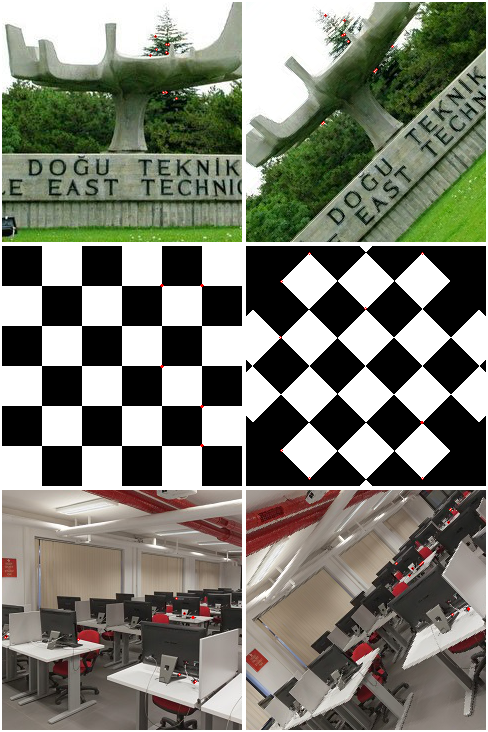

In [4]:
## Write your code here

def get_shift_filter(x, y):
    k = np.zeros((3,3))
    k[y+1, x+1] = 1
    return k


def compute_vectorized_ssd(img: np.ndarray):
    ssd = 0
    for u, v in GRADIENT_DIRECTIONS:
        shifted_img = convolve2d(img, get_shift_filter(u, v), mode="valid")
        ssd += np.square(shifted_img - img[1:-1, 1:-1])
    ssd = np.pad(ssd, 1)
    return ssd.astype(int)


def compute_ssd(img: np.ndarray, pos: Tuple[int, int]):
    x, y = pos    
    ssd = 0
    for u, v in GRADIENT_DIRECTIONS:
        # Need to cast higher bit integer types to encounter overflow
        ssd += np.square(img[x+u,y+v].astype(np.int32) - img[x,y].astype(np.int32))
    return ssd.astype(int)



@timing
def naive_harris(img: np.ndarray):
    """
    Implements naive harris method by looping over all pixels.
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    ssds = np.zeros_like(img, dtype=float)
    for x in range(1, m-1):
        for y in range(1, n-1):
            ssds[x, y] = compute_ssd(img, (x,y))
    
    return get_topk(img, ssds)


@timing
def naive_harris_vectorized(img: np.ndarray):
    """
    Implements naive Harris method by utilizing convolution on image. Unlike 
    `naive_harris()`, this function shifts image in 8 directions by convolution, 
    and then use the resulting shifted images to compute pixel SSDs in a 
    vectorized way.
    
    The implementation computes `M_i = (X - X'_i)^2` where i is 8 (unit) 
    directions, M_i is the elementwise squared difference matrix, X is the original
    image, and X_i is the shifted version of X in direction i. Shifting is carried 
    out by 2d (3,3) convolution filter.
    
    Args:
        img: 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    ssds = compute_vectorized_ssd(img)
    corners = get_topk(img, ssds)
    return corners


def test_equal():
    print("Testing if vectorized and naive version outputs are equal.")
    img = load_image("agac.png")
    ssd_vectorized = naive_harris_vectorized(img)
    ssd_naive = naive_harris(img)
    assert np.array_equal(ssd_vectorized, ssd_naive)
    print("Test is successful!")
    print("=" * 60)


test_equal()
draw_corners_on_fixtures(naive_harris_vectorized, save_as="task_1.png")

## Discussion - Task1

First of all, we implemented the naive method in two different ways. The first one is by using the native for loops to iterate over pixels and again loop over to computes 8-way direction difference for each region patch. The second one is utilizing vectorization through numpy, instead of looping over image pixels and directions, we shift the image with convolution and compute the differences between image array and shifted version of them. The reduction by utilizing vectorization in terms of run time is dramatic and significant.

- **by native loops:** 1.9168 sec
- **by vectorization:** 0.0140 sec
- **improvement factor:** ~136x

The runtime for naive method with vectorization is around `130ms+-10ms` per image which is quite acceptable.

The resulting corners are visually satisfying, but they are mostly occuring at some specific regions, such as, the corners at the long tree in the background, the corners found on checkerboard (two near pixels at square corners). 

It is worth mentioning that the results are very close for both raw and associated rotated images, e.g. most of the corners that appear in the first image (tree in the background) also appear in the rotated version in a very similar way. Also, in the third image mostly the corners are at the same places (objectwise).

Thus, the consistency seems to be high with this method for rotation transformations although we cannot say that it is completely rotation invariant. I think this invariance is related to the rotation angle as it effectively changes neighboring pixels. 

### Task2: Naive Formula + Uniform Weighting + Non-Maximum Suppression

func:'naive_harris_nms' | took: 0.5955 sec
func:'naive_harris_nms' | took: 0.5945 sec
func:'naive_harris_nms' | took: 0.5925 sec
func:'naive_harris_nms' | took: 0.5935 sec
func:'naive_harris_nms' | took: 0.5945 sec
func:'naive_harris_nms' | took: 0.5955 sec


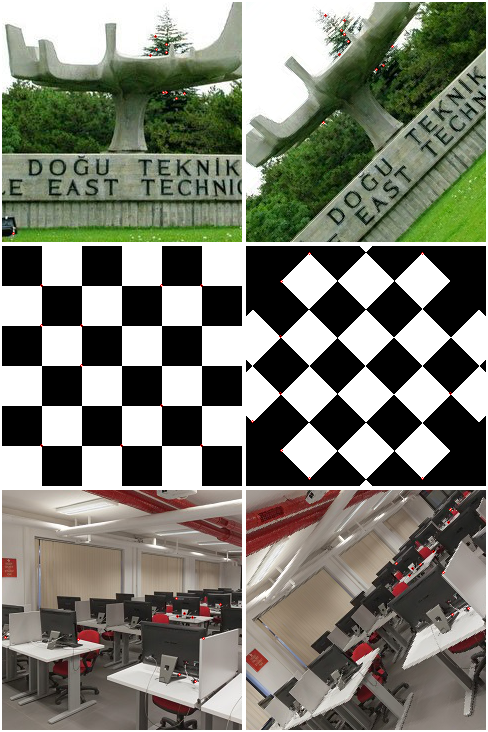

In [5]:
## Write your code here


@timing
def naive_harris_nms(img: np.ndarray):
    """
    Implements vectorized naive Harris + NMS. 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    ssds = compute_vectorized_ssd(img)
    ssds = local_non_maximum_supression(ssds, 1)
    corners = get_topk(img, ssds)
    return corners


draw_corners_on_fixtures(naive_harris_nms, save_as="task_2.png")

## Discussion - Task2

NMS significantly affected runtime and resulted in increase around `0.55 s` , this is a really high overhead compared to naive computations are done in `100 ms`.

NMS seems helped with the detected proximal/near corners. It is easier to see this effect from the checkerboard example, where now the found corners look scattered over several distinct corners. It also helped separating few near corners on the tree and the lab examples, but with few corners. Note that we used local NMS with only looking at neighboring pixels (1 unit proximity), and if we were to increase the window size of NMS, we would've seen more diverse corners on the images as the margin would be higher. However, increasing the window size of NMS too much would be harmful as it may eliminate useful signals also. We've experimented with 3 (`"task2.png"`), 5,7 and 9, and saw the increase in diversity.

### Task3: Taylor's Approximation + Uniform Weighting + Non-Maximum Suppression

func:'harris_taylor_approximation' | took: 1.4612 sec
func:'harris_taylor_approximation' | took: 1.4613 sec
func:'harris_taylor_approximation' | took: 1.4650 sec
func:'harris_taylor_approximation' | took: 1.4609 sec
func:'harris_taylor_approximation' | took: 1.4575 sec
func:'harris_taylor_approximation' | took: 1.4589 sec


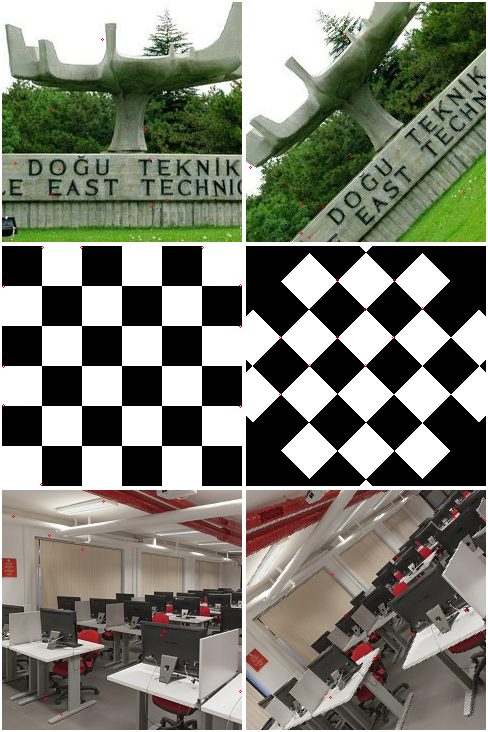

In [6]:
## Write your code here


def compute_ssd_taylor(H: np.ndarray, pos: Tuple[int, int]):
    """
    Implements Taylor computation in a vectorized way. It utilizes 
    vectorization by matrix multiplication of 8 directions 
    simultaneously and computes the resulting matrix trace. This is 
    identical to compute each of eight direction individually and 
    then take the sum.
    """
    x, y = pos
    ssd = 0
    M = H[:,:,x-1:x+2, y-1:y+2].sum(axis=-1).sum(axis=-1)
    t = GRADIENT_DIRECTIONS  # (8,2)
    ssd = (t @ M @ t.T) / 8  # Maximizing mean instead of sum mitigate overflow
    return np.trace(ssd)  


@timing
def harris_taylor_approximation(img: np.ndarray):
    """
    Implements vectorized naive Harris + NMS. 
    
    ref: https://github.com/opencv/opencv/blob/17234f82d025e3bbfbf611089637e5aa2038e7b8/modules/imgproc/src/corner.cpp#L238
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    
    gx, gy = sobel(img)
    gxy = gx*gy

    H = np.array([
        [gx**2, gxy], 
        [gxy, gy**2]
    ])  # (2,2,m,n)
    ssds = np.zeros_like(img)

    # Ignore image boundaries
    for x in range(1, m-1):
        for y in range(1, n-1):
            ssds[x, y] = compute_ssd_taylor(H, (x, y))
            
    ssds = local_non_maximum_supression(ssds, 1)
    corners = get_topk(img, ssds)
    return corners


draw_corners_on_fixtures(harris_taylor_approximation, save_as="task_3.png")

## Discussion - Task3

Taylor Approximation + NMS implementation has a runtime of `1.370 sec` per image. The naive + NMS was around `0.55 sec`, so we added overhead by roughly `800 ms` with Taylor approximation. It seems that runtime got worse and detected corners are also worse in terms of visual comparison.

Since this is an approximation solution we would expect to sacrifice detection performance by improving time complexity. If we didn't compare against the results obtained by vectorization trick, we would be comparing with `1.90 sec (naive-loop)`, and we see an improvement with a significant margin of around `530 ms` or 1.38x speed up. Note that we use matrix multiplication in computing shifting error.

The checkerboard serves as a test fixture, so we would expect any detection algorithm we implement to find corners of squares, here which Taylor approximation is successful for both raw checkerboard image and the rotated version. On the other hand, if we look at the first picture, for example, it detected a flat region (in the sky) near an edge, it is probably due to the approximation error as we only use the first-order derivatives. However, in general it is not visually satisfying, neither for raw nor for rotated images except checkerboard which can be counted as the only successful outcome.

### Task 4: Smaller Eigenvalue as corner score + Uniform Weighting + Non-Maximum Suppression

func:'harris_smaller_eig' | took: 2.3049 sec
func:'harris_smaller_eig' | took: 2.2864 sec
func:'harris_smaller_eig' | took: 2.2380 sec
func:'harris_smaller_eig' | took: 2.2460 sec
func:'harris_smaller_eig' | took: 2.2887 sec
func:'harris_smaller_eig' | took: 2.2902 sec


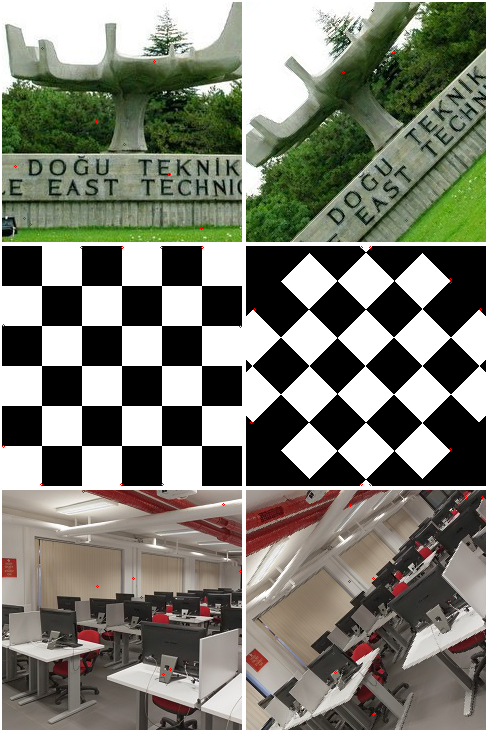

In [7]:
## Write your code here


def compute_min_eigv(H: np.ndarray, pos: Tuple[int, int]):
    """
    Returns minimum eigenvalue of matrix M(x,y) computed 
    using given H.
    """
    x, y = pos
    ssd = 0
    M = H[:,:,x-1:x+2, y-1:y+2].sum(axis=-1).sum(axis=-1)
    eig, _ = np.linalg.eig(M)
    return min(eig)


@timing
def harris_smaller_eig(img: np.ndarray):
    """
    Implements Harris with smaller eigen value. 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    
    gx, gy = sobel(img)
    gxy = gx*gy

    H = np.array([
        [gx**2, gxy], 
        [gxy, gy**2]
    ])  # (2,2,m,n)
    eigv2 = np.zeros_like(img)

    for x in range(1, m-1):
        for y in range(1, n-1):
            eigv2[x, y] = compute_min_eigv(H, (x, y))
            
    eigv2 = local_non_maximum_supression(eigv2, 1)
    corners = get_topk(img, eigv2)
    return corners


draw_corners_on_fixtures(harris_smaller_eig, save_as="task_4.png")

## Discussion - Task4

Replacing computation error from 8 directions on matrix M by smaller eigenvalue has added an overhead about `600 ms +-10` compared to Task 3. However, the results with eigenvalue seem better than Task3. The reason for that might be the fact that we try to fit an ellipse geometrically, and look at the minor axis. That is, we try to infer a continuous domain around the pixel neighborhood from computed gradients (discrete). If the ellipse is elongated, we would expect an edge, for a corner the ellipse should be close to a circle.  

With smaller eigenvalues, the results seems more refined compared to Task3. The corner found in the flat region at the first and the third image are no more, and also the detected points look more like a corner compared to Task3. Also, there are still some corners detected on flat regions, (e.g 3rd raw-image on the curtain), but there is a color shift on that curtain around the detected point, so it's not too bad. Still, visually the detected points/corners are less satisfying than naive Harris and we also not good enough in runtime.


### Task 5: R function as corner score + Uniform Weighting + Non-Maximum Suppression

func:'harris_response' | took: 0.5925 sec
func:'harris_response' | took: 0.5975 sec
func:'harris_response' | took: 0.5972 sec
func:'harris_response' | took: 0.6018 sec
func:'harris_response' | took: 0.5950 sec
func:'harris_response' | took: 0.5954 sec


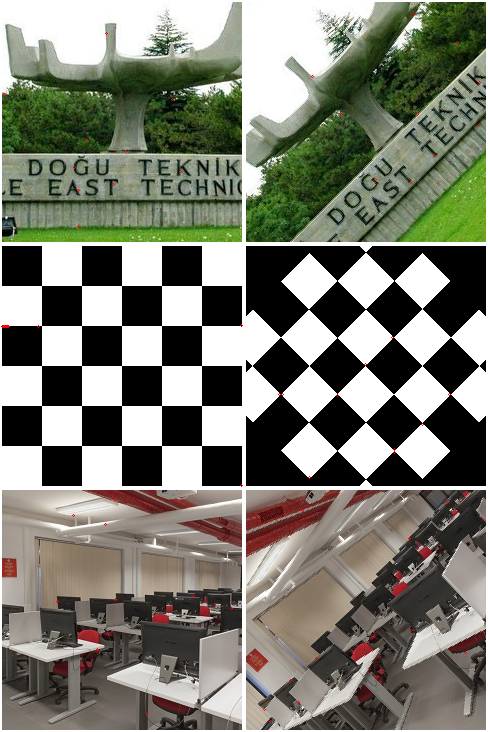

In [8]:
## Write your code here


@timing
def harris_response(img: np.ndarray, alpha: float = 0.04):
    """
    Implements Harris Operator. 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    
    gx, gy = sobel(img)
    gxy = gx * gy

    H = np.array([
        [gx**2, gxy], 
        [gxy, gy**2]
    ])  # (2,2,m,n)
    H_det = np.linalg.det(H.transpose((2, 3, 0, 1)))  # (m,n)
    H_trace = np.trace(H)  # (m,n)
    R = H_det - alpha * (H_trace ** 2)
    R = filter_boundary_pixels(R)
    R = local_non_maximum_supression(R, 1)
    corners = get_topk(img, R)
    return corners


draw_corners_on_fixtures(harris_response, save_as="task_5.png")

## Discussion - Task5

The runtime improved compared to Task3 and Task4. If we compare runtimes in order:

- **Task3:** 1.37 sec | Relative: -
- **Task4:** 2 sec    | Relative: 1.45x slower (comp. Task3)
- **Task5:** 0.57 sec | Relative: 3.51x faster (comp. Task4)

Now we have a runtime `0.57 sec` which is almost the same as vectorized Harris + NMS (Task2). 

For the detected corners, few instant things appear:
- Compared to task 4, there are less corners detected around flat-ish regions.
- The detected corners look more like a corner, again compared to 4 (we took color shifts into account on detected corners for task 4), but on task 5 the corners are distinguishibly corners.

### Task 6: R function with fast windowing based on fitering + Uniform Weighting + Non-Maximum Suppression

func:'harris_response_fast_windowing' | took: 0.5999 sec
func:'harris_response_fast_windowing' | took: 0.6005 sec
func:'harris_response_fast_windowing' | took: 0.5975 sec
func:'harris_response_fast_windowing' | took: 0.5976 sec
func:'harris_response_fast_windowing' | took: 0.6005 sec
func:'harris_response_fast_windowing' | took: 0.5995 sec


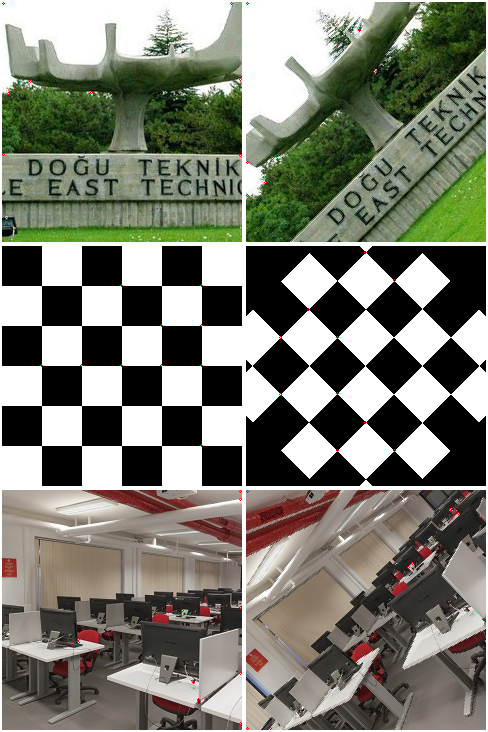

In [9]:
## Write your code here

BOX_FILTER = np.array(
    [[1,1,1],
     [1,1,1],
     [1,1,1]]
) / 9


@timing
def harris_response_fast_windowing(img: np.ndarray, smoothing_filter: np.ndarray, alpha: float = 0.04):
    """
    Implements Harris with a Response function with smoothing. 
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    H_padding = ((0,0), (0, 0), (1, 1), (1, 1))
    
    gx, gy = sobel(img)
    gx2, gy2 = gx**2, gy**2
    gxy = gx*gy
    
    fgx = convolve2d(gx2, smoothing_filter, mode="same")
    fgy = convolve2d(gy2, smoothing_filter, mode="same")
    fgxy = convolve2d(gxy, smoothing_filter, mode="same")

    H = np.array([[fgx, fgxy], [fgxy, fgy]])  # (2,2,m,n)
    H_det = np.linalg.det(H.transpose((2, 3, 0, 1)))  # (m,n)
    H_trace = np.trace(H)  # (m,n)
    R = H_det - alpha * (H_trace ** 2)
    R = filter_boundary_pixels(R)
    R = local_non_maximum_supression(R, 1)
    corners = get_topk(img, R)
    return corners


draw_corners_on_fixtures(
    harris_response_fast_windowing, 
    smoothing_filter=BOX_FILTER,
    save_as="task_6.png"
)

## Discussion - Task6

The runtime difference of Task6 and Task5 is neglible, so there's not much overhead we added. However, in terms of detection performance, smoothing the derivatives highly affected. We have some kind of rotation invariance now, this was not easily spotted, or even not the case at all for earlier tasks, except for tasks 1 and 2 (naive Harris implementations). We were trying to approximate naive Harris implementation, but we kind of lost the rotation invariance a bit (this is one thing among many). However, it seems that we have recovered the rotation invariance by adding smoothing filter.

### Task 7: R function with fast windowing based on fitering + Gaussian Weighting + Non-Maximum Suppression

func:'harris_response_fast_windowing' | took: 0.6048 sec
func:'harris_response_fast_windowing' | took: 0.6025 sec
func:'harris_response_fast_windowing' | took: 0.5957 sec
func:'harris_response_fast_windowing' | took: 0.5995 sec
func:'harris_response_fast_windowing' | took: 0.6025 sec
func:'harris_response_fast_windowing' | took: 0.5995 sec


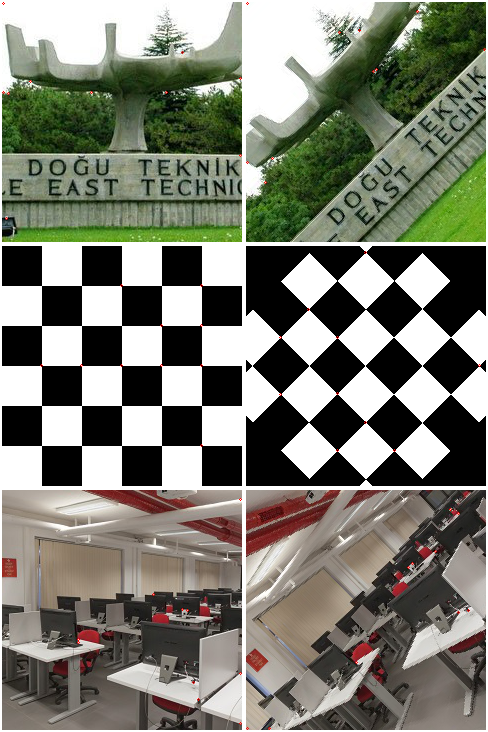

In [10]:
## Write your code here

GAUSSIAN_FILTER = np.array(
    [[1,2,1],
     [2,4,2],
     [1,2,1]]
) / 16


draw_corners_on_fixtures(
    harris_response_fast_windowing,
    smoothing_filter=GAUSSIAN_FILTER, 
    save_as="task_7.png"
)

## Discussion - Task7

There's little to no difference between Task6 and Task7, both of the them from the test images we have seems successful in terms of detection. To be clear, most of the detected corners are common between Task6 and Task7, and the different detected corners that are detected with either filter are visually satisfying. **Without too much confidence** and with these 6 test images, I might hypothesize that Gaussian filter may help with the rotation invariance more.

In [11]:
def save_gif():
    images = []
    for img_path in OUTPUT_DIR.glob("*"):
        if img_path.name.startswith("_"):
            continue
        img = PIL.Image.open(img_path)
        draw = ImageDraw.Draw(img)
        draw.text((0,0), f"{img_path.name}", "black")
        images.append(img)
    images[0].save("all_outputs.gif", save_all=True, append_images=images[1:], optimize=False, duration=2800, loop=0)
    
save_gif()